In [63]:
# import library 
import pandas as pd 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [17]:
# Read the dataset
df_taxi = pd.read_parquet('../00-Dataset/green_tripdata_2021-01.parquet')

# Show the data
df_taxi.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [18]:
# show the dtype of dataset
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[ns]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [19]:
# Adjust dropoff & pickup to pandas datetime 
df_taxi['lpep_pickup_datetime'] = pd.to_datetime(df_taxi.lpep_pickup_datetime)
df_taxi['lpep_dropoff_datetime'] = pd.to_datetime(df_taxi.lpep_dropoff_datetime)

In [20]:
# Calculate the duration (drop_off -  pick_up)
df_taxi['duration'] = df_taxi.lpep_dropoff_datetime - df_taxi.lpep_pickup_datetime

# show the result 
df_taxi.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04


In [21]:
# Adjust the duration in minutes for prediction 
df_taxi['duration_minutes'] = df_taxi['duration'].dt.total_seconds() / 60

# show the result 
df_taxi.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,duration_minutes
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04,0.066667


count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration_minutes, dtype: float64


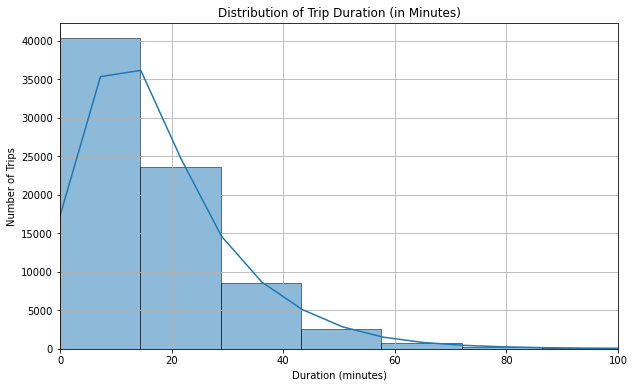

In [22]:
# Look at the distribution of the duration_minutes 
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print(df_taxi['duration_minutes'].describe())

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_taxi['duration_minutes'], bins=100, kde=True)
plt.title('Distribution of Trip Duration (in Minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Trips')
plt.xlim(0, 100)  # Limit x-axis to exclude extreme outliers
plt.grid(True)
plt.show()

In [23]:
# Since there are a lot of duration less than 1 minutes. We filter only duration between 1 minutes to 99% percentile
df_taxi = df_taxi[(df_taxi['duration_minutes'] >= 1) & (df_taxi['duration_minutes'] <= 60)]


# show the result 
df_taxi.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,duration_minutes
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,0 days 00:02:19,2.316667


In [24]:
# Feature Engineering 
categorical_variables = ['PULocationID', 'DOLocationID']
numerical_variables = ['trip_distance']

In [25]:
# Check the types of categorical variables
df_taxi[categorical_variables].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [26]:
# Convert it into "str"
df_taxi[categorical_variables] = df_taxi[categorical_variables].astype(str)

# Check the result 
df_taxi[categorical_variables].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [28]:
# Show the variables for training 
df_taxi[categorical_variables + numerical_variables].head(10)

,PULocationID,DOLocationID,trip_distance
0,43,151,1.01
1,166,239,2.53
2,41,42,1.12
3,168,75,1.99
7,75,75,0.45
9,225,265,12.19
10,244,244,3.39
11,75,213,6.69
12,74,238,2.34
13,74,60,5.48


In [35]:
# Convert it into dictionary 
train_dicts = df_taxi[categorical_variables + numerical_variables].to_dict(orient = 'records')

In [36]:
# Vectorizer the training variables 
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)

# Show the result 
X_train 

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [37]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [40]:
# Setup the Prediction_Variables 
predictor = 'duration_minutes'
y_train = df_taxi[predictor].values

# Show the result 
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [44]:
# Train the model 
lr = LinearRegression() 
lr.fit(X_train, y_train)

LinearRegression()

In [45]:
# Make a prediction 
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


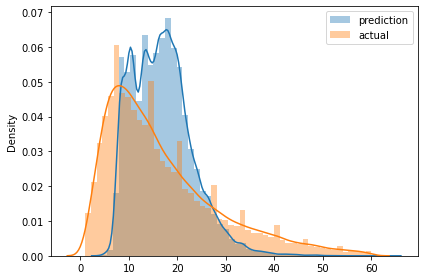

In [48]:
# Visualize the prediction and actual 
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()
plt.tight_layout()

In [50]:
# Calculate the performance (RMSE)
mean_squared_error(y_train, y_pred, squared = False)

9.7754640491756

### Put all the proccessing into a function

In [56]:
def read_dataframe(filename):
    "Write a function to read and preprocessing data"
    # Read the dataset
    df_taxi = pd.read_parquet(filename)

    # Adjust dropoff & pickup to pandas datetime 
    df_taxi['lpep_pickup_datetime'] = pd.to_datetime(df_taxi.lpep_pickup_datetime)
    df_taxi['lpep_dropoff_datetime'] = pd.to_datetime(df_taxi.lpep_dropoff_datetime)
    
    # Calculate the duration (drop_off -  pick_up)
    df_taxi['duration'] = df_taxi.lpep_dropoff_datetime - df_taxi.lpep_pickup_datetime
    
    # Adjust the duration in minutes for prediction 
    df_taxi['duration_minutes'] = df_taxi['duration'].dt.total_seconds() / 60

    # Since there are a lot of duration less than 1 minutes. We filter only duration between 1 minutes to 99% percentile
    df_taxi = df_taxi[(df_taxi['duration_minutes'] >= 1) & (df_taxi['duration_minutes'] <= 60)]

    # Feature Engineering 
    categorical_variables = ['PULocationID', 'DOLocationID']
    numerical_variables = ['trip_distance']

    # Convert it into "str"
    df_taxi[categorical_variables] = df_taxi[categorical_variables].astype(str)
    
    return df_taxi

In [57]:
df_train = read_dataframe('../00-Dataset/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../00-Dataset/green_tripdata_2021-02.parquet')

In [58]:
len(df_train), len(df_val)

(73908, 61921)

### Create the training pipeline 

In [71]:
# Feature Engineering 
categorical_variables = ['PULocationID', 'DOLocationID']
numerical_variables = ['trip_distance']

# Vectorizer the training variables 
dv = DictVectorizer()

# Convert it into dictionary 
train_dicts = df_train[categorical_variables + numerical_variables].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

# Create the validation set 
val_dicts = df_val[categorical_variables + numerical_variables].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [72]:
# Setup the Prediction_Variables 
predictor = 'duration_minutes'
y_train = df_train[predictor].values
y_val = df_val[predictor].values

In [73]:
# Train the model 
lr = LinearRegression() 
lr.fit(X_train, y_train)

# Make a prediction 
y_pred = lr.predict(X_val)

# Calculate the performance (RMSE)
mean_squared_error(y_val, y_pred, squared = False) 

10.47390313604031

### Try with Lasso Regression

In [74]:
# Train the model 
lr = Lasso(alpha= 0.0001) 
lr.fit(X_train, y_train)

# Make a prediction 
y_pred = lr.predict(X_val)

# Calculate the performance (RMSE)
mean_squared_error(y_val, y_pred, squared = False) 

10.47054920225702

### Try To Combine the input features 

In [75]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [76]:
# Feature Engineering 
categorical_variables = ['PU_DO']  #['PULocationID', 'DOLocationID']
numerical_variables = ['trip_distance']

# Vectorizer the training variables 
dv = DictVectorizer()

# Convert it into dictionary 
train_dicts = df_train[categorical_variables + numerical_variables].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

# Create the validation set 
val_dicts = df_val[categorical_variables + numerical_variables].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [77]:
# Setup the Prediction_Variables 
predictor = 'duration_minutes'
y_train = df_train[predictor].values
y_val = df_val[predictor].values

In [78]:
# Train the model 
lr = LinearRegression() 
lr.fit(X_train, y_train)

# Make a prediction 
y_pred = lr.predict(X_val)

# Calculate the performance (RMSE)
mean_squared_error(y_val, y_pred, squared = False) 

7.479586896299878